## Classifying and Natural Language Processing with Yelp Reviews Data
#### W207 Section 3, Group - <span style="color:orange"><strong>C</strong></span>olors
#### Summer, 2018
#### Team members:
- Chandra Sekar, chandra-sekar@ischool.berkeley.edu
- Guangyu (Gary) Pei, guangyu.pei@ischool.berkeley.edu
- Jooyeon (Irene) Seo, jooyeon@ischool.berkeley.edu
- Sijie (Anne) Yu, syu.anne@berkeley.edu

In [1]:
# General libraries.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# SK-learn libraries for learning.
# import sklearn
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# keras package for neural networks.
from keras import models
from keras import layers
from keras import optimizers

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Config Jupyter session
%config IPCompleter.greedy=True

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Global configurations
np.set_printoptions(precision=4, suppress=True)

# Config system logs
import logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s %(levelname)s %(message)s')

# print versions
print("Python version used:", sys.version)
print("Numpy version used:", np.__version__)
print("sklearn version used:", sklearn.__version__)

/Users/briannaseo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/briannaseo/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/briannaseo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float)

Python version used: 3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version used: 1.14.2
sklearn version used: 0.19.1


#### Goals
Our project’s primary concept is to utilize Yelp data (from kaggle) to rate new business. That is, we are going to get Yelp user review data, use review texts to predict review is **positive** or **negative**. When people talk about a new business, we can capture their words, fit into the model, then predict its rating, sort of understand its quality and potential.

#### The Yelp Review Dataset
We write a shell [script](https://github.com/annesjyu/m207_summer_2018) to select $10,000$ reviews for training, testing and dev respectively, each set consisting in 50% negative and 50% positive reviews. We keep only review text and stars columns, then binarize stars into target label: 
- if starts >= $3.0$, review is *positive*
- otherwise, it's *negative*.

The following code will load the dataset and split it into $3$ sets:

In [13]:
with np.warnings.catch_warnings():
    # There are some bad data, we just dont want to see a lot of warning messages
    np.warnings.filterwarnings('ignore', r'Some errors were detected')
    data = np.genfromtxt('data.csv',dtype='str', delimiter='|', skip_header=1, 
                         usecols = (0,1), invalid_raise=False, loose=True)

    print ("Full data dim: ", data.shape)
    
    # Shuffle the data, each dataset will have roughly the same number of examples for each label.
    shuffle = np.random.permutation(np.arange(data.shape[0]))
    X, Y = data[shuffle, 0], data[shuffle, 1]    
    
    train_data, train_labels = X[0:12000], Y[:12000].astype(np.int)
    test_data, test_labels = X[12000:22000], Y[12000:22000].astype(np.int)
    dev_data, dev_labels = X[22000:-1], Y[22000:-1].astype(np.int)

    NUM_OF_TRAINING_DATA = len(train_data)
    NUM_OF_TESTING_DATA = len(test_data)
    NUM_OF_DEV_DATA = len(dev_data)

    print ('train data size: ', NUM_OF_TRAINING_DATA)
    print ('test data size: ', NUM_OF_TESTING_DATA)
    print ('dev data size: ', NUM_OF_DEV_DATA)
    print ('_'*80)
    print ('Training examples:\n', train_data[0:2])
    print (train_labels[0:2])
    print ('_'*80)
    print ('Testing examples:\n', test_data[0:2])
    print (test_labels[0:2])
    print ('_'*80)
    print ('Dev examples:\n', dev_data[0:2])
    print (dev_labels[0:2])

Full data dim:  (29701, 2)
train data size:  12000
test data size:  10000
dev data size:  7700
________________________________________________________________________________
Training examples:
 ["This little hole-in-the-wall has exceptional food. Perfect for a date. I bet I've eaten here a half-dozen times and the quality has always been consistent. Not ideal for bigger parties  as there are only a few tables that seat more than four. In fact  most of the tables are for two  but you can get away with squeezing a third person in there if you like to cozy up with your dinner guests. Outside of the food  I like it because it's quiet. In fact  I've never seen more than a few tables occupied with any visit. It almost makes me wonder how they stay in business (possibly take-out). I hope they do  'cause I'd sure miss their food. "
 "One look at the menu and I was ready to tough out the parking woes of going to the Plaza. You can order any pizza by the slice or so it seems. Upon ordering we 

Analyze train, dev and test datasets to find out data distributions. Ideally we want to have 50% examples for either label.

In [14]:
print ('positive train data: ', len(np.where(train_labels==1)[0]), 
       ', negative train data: ', len(np.where(train_labels==0)[0]))
print ('positive test data: ', len(np.where(test_labels==1)[0]), 
       ', negative test data: ', len(np.where(test_labels==0)[0]))
print ('positive dev data: ', len(np.where(dev_labels==1)[0]), 
       ', negative dev data: ', len(np.where(dev_labels==0)[0]))

positive train data:  5980 , negative train data:  6020
positive test data:  5041 , negative test data:  4959
positive dev data:  3842 , negative dev data:  3858


In [4]:
def load_data(fnm = "data_restaurants_reviews_30_to_200_stars_1_5", seed = 1234,
              train_frac= 0.8, dev_size = 1000):
    data = pd.read_pickle(fnm)
    np.random.seed(seed)
    data = data.sample(frac=1).reset_index(drop=True)
    print ("Total data size:", data.shape[0])
    traing_size = int(np.floor(data.shape[0]*train_frac))
    test_size = int(np.floor(data.shape[0]*(1.0-train_frac))) - dev_size
    train_data, train_labels = data.X[0:traing_size], data.Y[0:traing_size]
    test_data, test_labels = data.X[traing_size:(traing_size+test_size)], data.Y[traing_size:(traing_size+test_size)]
    dev_data, dev_labels = data.X[(traing_size+test_size):-1], data.Y[(traing_size+test_size):-1]
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels
    

train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_data()

print ('train data size: ', train_data.shape)
print ('test data size: ', test_data.shape)
print ('dev data size: ', dev_data.shape)

Total data size: 30000
train data size:  (24000,)
test data size:  (4999,)
dev data size:  (1000,)


#### Natural Language Processing on Review Texts

We will create a doc-term matrix from review texts, so that classifiers can use it as an feature. There are a couple of steps of doing it. 
- First of all we will conduct Natural Language Processing with customized stemmer, stop words etc. 
- Secondly we will use Logistic Regression + L1 Regulization to reduce non-important terms.

In [15]:
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words

categories = ['Positive reviews', 'Negative reviews']

def NLP_text(verbose):
    """The function will take a vector of texts and create a Doc-Term Matrix.
    Input:
        verbose: if true, will print debug info.
    Output:
        a customized vectorizer object.
    """    
    def better_tokenizer(s):
        tokens = TfidfVectorizer().build_tokenizer()(s)
        # create English stop words list
        stop_words = get_stop_words('en')
        
        # Create p_stemmer of class PorterStemmer
        p_stemmer = PorterStemmer()
        
        # We compute the average length of original dictionary, which is 6.7
        # then ignore extremly short and long words, like more than 6.7/2 and 6.7*2.
        WORD_LEN = 6.7
        
        return [p_stemmer.stem(t) for t in tokens if len(t) >= WORD_LEN/2 
                and len(t) <= WORD_LEN*2 and t not in stop_words]
           
    shuffle = np.random.permutation(train_data.shape[0])
    X, Y = train_data[shuffle], train_labels[shuffle]
    TUNE_DATA_SIZE = int(len(train_data)/6)
    data = X[0:TUNE_DATA_SIZE]
    labels = Y[0:TUNE_DATA_SIZE]
    
    vect1 = TfidfVectorizer(strip_accents='ascii', ngram_range=(1,1), min_df=2, 
                            stop_words='english', use_idf=False, sublinear_tf=True, 
                            max_features=10000, tokenizer=better_tokenizer)
    
    data_dtm = vect1.fit_transform(data)
    features = vect1.get_feature_names()
    print ('num of original terms: ', len(features))

    # Reduce terms using Logistic Regression + L1 regulirization
    # If the the term has a non-zero weight we will keep it, otherwise, exclude it from DTM.
    Logistic_Regression_optimal_C = 10
    lg = LogisticRegression(penalty="l1", tol=0.01, C=Logistic_Regression_optimal_C)
    lg.fit(data_dtm, labels)
    print ('dim of coef matrix: ', lg.coef_.shape)
    #print ('accuracy: ', metrics.accuracy_score(labels, lg.predict(test_data, test_labels)))
    
    nonzero_features_indices = np.array(np.nonzero(lg.coef_[0])[0])
    print ('num of nonzero terms: ', nonzero_features_indices.shape)
    
    reduced_terms = [features[int(w)] for w in nonzero_features_indices]
    if verbose:
        print ('non-zero terms:\n%s' %reduced_terms)
    
    vect2 = TfidfVectorizer(strip_accents='ascii', ngram_range=(1,1), min_df=2, 
                            use_idf=False, sublinear_tf=True, 
                            tokenizer=better_tokenizer, 
                            vocabulary=reduced_terms)
    
    return vect2

# Get the customized and improved vectorizer
verbose = False
start = time.time()
#better_vect = NLP_text(verbose)
print ('done in ', time.time() - start, ' s')

done in  4.00543212890625e-05  s


##### Create a baseline using default CountVectorizer and NB

In [16]:
v = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
train_dtm = v.fit_transform(train_data)
print (train_dtm.shape)

bnb = BernoulliNB(alpha=0.01)
bnb.fit(train_dtm, train_labels)
predicted = bnb.predict(v.transform(dev_data))

print (classification_report(predicted, dev_labels))

terms = v.get_feature_names()
top100 = np.argsort(bnb.coef_[0])[-100:]
print ('top 100 terms:\n',[terms[int(w)] for w in top100])
print ('_'*80)
bottom100 = np.argsort(bnb.coef_[0])[:100]
print ('lest important 100 terms:\n',[terms[int(w)] for w in bottom100])
print ('_'*80)

(12000, 5405)
             precision    recall  f1-score   support

          0       0.77      0.86      0.81      3437
          1       0.88      0.79      0.83      4263

avg / total       0.83      0.82      0.82      7700

top 100 terms:
 ['perfect', 'check', 'bad', 'inside', 'places', 'took', 'table', 'different', 'selection', 'salad', 'work', 'vegas', 'hot', 'dinner', 'meal', 'home', 'favorite', 'worth', 'quite', 'overall', 'sweet', 'need', 'looking', 'drinks', 'long', 'price', 'excellent', 'happy', 'tried', 'location', 'super', 'thing', 'big', 'prices', 'feel', 'clean', 'wasn', 'times', 'cheese', 'sauce', 'lunch', 'awesome', 'lot', 'night', 'say', 'new', 'want', 'bar', 'eat', 'small', 'area', 'fresh', 'bit', 'wait', 'going', 'll', 'way', 'experience', 'sure', 'recommend', 'chicken', 'right', 'day', 'went', 'know', 'better', 'think', 'people', 'did', 'order', 'amazing', 'didn', 'restaurant', 'make', 'ordered', 'come', 'menu', 'came', 'delicious', 'got', 'pretty', 'staff', 'try'

##### Logistic Regression Model

In this section, we will train Logistic Regression model.

Number of nonzero weights with l1 penalty is 2021.
Number of nonzero weights with l2 penalty is 5405.
Best F1 score with L2 regularization is 0.87.
The best F1 score is achieved by using the vocabulary size 3780 determined by L1 regularization with C parameter 8.85867


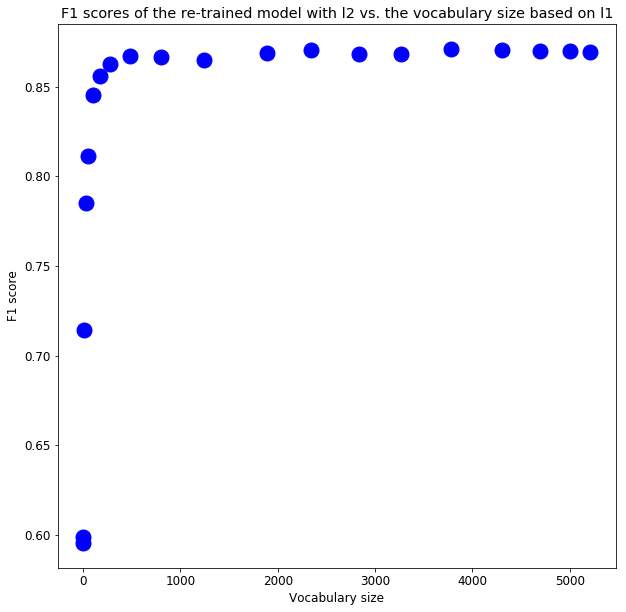

In [17]:
def yelp_review_logistic_regression_model(train_data = train_data,
                                          train_labels = train_labels,
                                          test_data = dev_data,
                                          test_labels = dev_labels,
                                          seed = 1234):
    # Keep this random seed so that this function is reproducible.
    np.random.seed(seed)
    count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
    dtm_train = count_vectorizer.fit_transform(train_data)
    # compare the number of nonzero weights from l1 and l2
    logistic_l1 = LogisticRegression(penalty="l1")
    logistic_l1.fit(dtm_train, train_labels)
    # Method 1 using np.nonzero
    print("Number of nonzero weights with l1 penalty is {:d}.".format(len(set((np.nonzero(logistic_l1.coef_))[1]))))
    logistic_l2 = LogisticRegression(penalty="l2")
    logistic_l2.fit(dtm_train, train_labels)
    print("Number of nonzero weights with l2 penalty is {:d}.".format(len(set((np.nonzero(logistic_l2.coef_))[1]))))
    
    # vary C parameters and plot the graph
    vocabsizes = []
    l1_cs = []
    f1_scores = []
    for i in np.logspace(-3, 2, num=20):
        logistic_l1 = LogisticRegression(penalty="l1", tol=0.01, C=i)
        logistic_l1.fit(dtm_train, train_labels)
        # features that have at least one non-zero weights under l1 penalty
        l1_nonzero_vocab = np.array(count_vectorizer.get_feature_names())[list(set((np.nonzero(logistic_l1.coef_))[1]))]
        vocabsizes.append(len(l1_nonzero_vocab))
        l1_cs.append(i)
        # using vocabulary based on non-zero weights from l1 penalty logistic regression results
        vectorizer_with_reduced_vocab = CountVectorizer(vocabulary=l1_nonzero_vocab)
        dtm_with_reduced_vocab = vectorizer_with_reduced_vocab.fit_transform(train_data)
        dtm_test_with_reduced_vocab = vectorizer_with_reduced_vocab.transform(test_data)
        # fit logistic regression with penalty l2
        logistic_l2_retrain = LogisticRegression(penalty="l2")
        logistic_l2_retrain.fit(dtm_with_reduced_vocab, train_labels)
        f1_scores.append(metrics.f1_score(test_labels,
                                          logistic_l2_retrain.predict(dtm_test_with_reduced_vocab),
                                          average = 'macro'))
    
    # plot the results
    plt.figure(figsize=(10,10))
    plt.plot(vocabsizes, f1_scores, 'bo', markersize=15)
    plt.title('F1 scores of the re-trained model with l2 vs. the vocabulary size based on l1')
    plt.xlabel('Vocabulary size')
    plt.ylabel('F1 score')
    plt.rcParams["font.size"] = 12
    
    print("Best F1 score with L2 regularization is {:.2f}.\nThe best F1 score is achieved by using the vocabulary size {:d} determined by L1 regularization with C parameter {:.5f}"\
          .format(np.max(f1_scores),vocabsizes[np.argmax(f1_scores)],l1_cs[np.argmax(f1_scores)]))

yelp_review_logistic_regression_model()    

##### Neural Networks

In this section, we will train Neural Networks.

Train on 12000 samples, validate on 7700 samples
Epoch 1/20
12000/12000 [==============================] - 2s 139us/step - loss: 0.5470 - acc: 0.7927 - val_loss: 0.4441 - val_acc: 0.8656
Epoch 2/20
12000/12000 [==============================] - 1s 84us/step - loss: 0.3709 - acc: 0.8922 - val_loss: 0.3674 - val_acc: 0.8805
Epoch 3/20
12000/12000 [==============================] - 1s 85us/step - loss: 0.2901 - acc: 0.9145 - val_loss: 0.3329 - val_acc: 0.8851
Epoch 4/20
12000/12000 [==============================] - 1s 93us/step - loss: 0.2371 - acc: 0.9300 - val_loss: 0.3175 - val_acc: 0.8879
Epoch 5/20
12000/12000 [==============================] - 1s 86us/step - loss: 0.1969 - acc: 0.9407 - val_loss: 0.3174 - val_acc: 0.8860
Epoch 6/20
12000/12000 [==============================] - 1s 86us/step - loss: 0.1688 - acc: 0.9492 - val_loss: 0.3275 - val_acc: 0.8834
Epoch 7/20
12000/12000 [==============================] - 1s 86us/step - loss: 0.1447 - acc: 0.9543 - val_loss: 0.3451 - val_acc

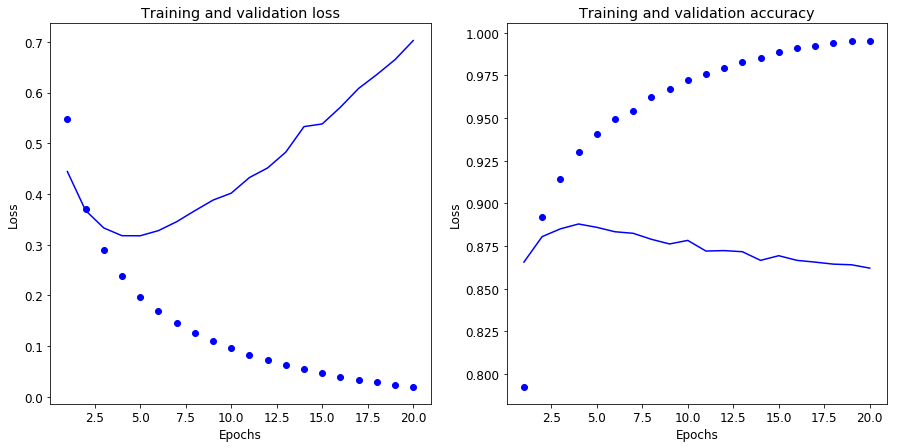

In [18]:
def yelp_review_neural_networks():

    count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
    dtm_train = count_vectorizer.fit_transform(train_data)
    dtm_dev = count_vectorizer.transform(dev_data)
    dtm_test = count_vectorizer.transform(test_data)

    # 1) Building our model with maximum 5,405 words
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(5405,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Use binary_crossentropy loss function because our model outputs probabilities
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(dtm_train, train_labels, epochs=20, batch_size=512, validation_data=(dtm_dev, dev_labels))
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation loss
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.plot(epochs, loss, 'bo', label='Training loss')
    ax.plot(epochs, val_loss, 'b', label='Validation loss')
    ax.set_title('Training and validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    
    # Plot training and validation accuracy
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    
yelp_review_neural_networks()

We see a clear minimum in validation loss function after 3rd epoch, and maximum in validation accuracy at 3rd epoch. We'll fit the model with 3 epochs.

In [20]:
def yelp_review_neural_networks():

    count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
    dtm_train = count_vectorizer.fit_transform(train_data)
    dtm_dev = count_vectorizer.transform(dev_data)
    dtm_test = count_vectorizer.transform(test_data)

    # 1) Building our model with maximum 5,405 words
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(5405,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Use binary_crossentropy loss function because our model outputs probabilities
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(dtm_train, train_labels, epochs=3, batch_size=512)
    results = model.evaluate(dtm_dev, dev_labels)
    print("Accuracy of Neural Network classifier is", "{:.2f}".format(results[1]))
    
yelp_review_neural_networks()

Epoch 1/3
12000/12000 [==============================] - 1s 104us/step - loss: 0.5595 - acc: 0.7949
Epoch 2/3
12000/12000 [==============================] - 1s 59us/step - loss: 0.3689 - acc: 0.8935
Epoch 3/3
7700/7700 [==============================] - 1s 85us/step
Accuracy of Neural Network classifier is 0.89


### Appendix: Exploratory Data Analysis

In this section, we present the Exploratory Data Analysis (EDA) for the Yelp review data set. The goals of EDA are: (1) understand the dataset characteristics; (2) identify the relationship between Yelp ratings and business quality such that meanful and practical supervised machine learning data set is constructed.

#### Load the raw data set into Pandas data frame

In [ ]:
start_time=time.time()
business=pd.read_csv("yelp_dataset/yelp_business.csv")
business_attributes=pd.read_csv("yelp_dataset/yelp_business_attributes.csv")
business_hours=pd.read_csv("yelp_dataset/yelp_business_hours.csv")
check_in=pd.read_csv("yelp_dataset/yelp_checkin.csv")
reviews=pd.read_csv("yelp_dataset/yelp_review.csv", nrows=17746270)
tip=pd.read_csv("yelp_dataset/yelp_tip.csv")
user=pd.read_csv("yelp_dataset/yelp_user.csv")
end_time=time.time()
print("Reading all cvs files took ",end_time-start_time,"s")

In [ ]:
print("Number of reviews {:d}".format(reviews.shape[0]))
reviews.head(5)

In [ ]:
print("Number of business {:d}.".format(business.shape[0]))
business.head(5)

#### Basic data characteristics

In [ ]:
# visualize the data characteristics
import seaborn as sns 
review_stars = reviews['stars'].value_counts().sort_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(review_stars.index, review_stars.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

The Yelp review star ratings are clearly not uniformly distributed. The reviews with 5 stars dominates among all reviews (more than 2 millions 5-star reviews).

In the following, let us look at the distribution of business categories.

In [ ]:
categories = pd.DataFrame(' '.join(business['categories']).split(';'),columns=['category'])\
            .category.value_counts().sort_values(ascending=False)
print("There are ",len(categories)," categories of Businesses in Yelp.")

plt.figure(figsize=(16,4))
ax = sns.barplot(categories[0:20].index, categories[0:20].values, alpha=0.8)
plt.title("Top 20 categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

The above figure shows that restaurant type is the top one business category. Clearly, it is hard to compare business from different categories. We can focus on restaurants since it is the most common business type on Yelp. In the following, we will investigate the number of reviews distritution for each restaurant.

In [ ]:
restaurant_review_cnt = business.loc[(business['categories'].str.lower().str.contains('restaurant'))]['review_count']
print(restaurant_review_cnt.describe())
plt.figure(figsize=(16,8))
sns.distplot(restaurant_review_cnt)
plt.ylabel('Distribution', fontsize=12)
plt.xlabel('Review count', fontsize=12)

The distribution and statistics show that 50% restaurants received $\le$ 18 reviews. The distribution is right skewed. Restaurants with small number of reviews are more likely biased. Based on the above distribution, we zoom in restaurants with 30 - 200 reviews. 

In [ ]:
restauntants_with_30_to_200_reviews = business.loc[(business['review_count'].isin(range(30,201))) & (business['categories'].str.lower().str.contains('restaurant'))]

plt.figure(figsize=(16,8))
sns.distplot(restauntants_with_30_to_200_reviews['review_count'], kde=False, rug=True, bins=50)
plt.ylabel('Number of restaurants', fontsize=12)
plt.xlabel('Review count', fontsize=12)

In [ ]:
reviews_merged_with_restauntants_with_30_to_200_reviews = pd.merge(reviews, restauntants_with_30_to_200_reviews, how = 'right', on = 'business_id')
print('Total number of reviews for restaunts that have 30 to 200 reviews:', reviews_merged_with_restauntants_with_30_to_200_reviews.shape[0])

Thus, we have more than 1.3 million reviews that were written for restaurants. Each of these restaurants has number of reviews between 30 to 200. In the following, we plot the number of reviews for each star ratings.

In [ ]:
x = reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'].value_counts().sort_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star rating counts for restaurants with 30-200 reviews")
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Star ratings ', fontsize=12)

In [ ]:
print("Number of reviews with 1 star rating: ", reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] <2].shape[0])
print("Number of reviews with 5 star rating: ", reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] >4].shape[0])

This distribution is very similar to ratings distribution we plotted earlier for the full data set. In another words, after we filtered the data set with business category restaurants and number of reviews for each restaurant, the star rating distribution remains the same. In the following, we randomly select 15000 from reviews with rating 1 (less than 10% of all reviews with 1 stars) and 15000 reviews with rating 5 (about 3% of total 5 star reviews). We use this random sampled data to explore the characteritics of the text and business sentiments.

In [ ]:
np.random.seed(0)
negative_samples = reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] <2].sample(15000)
positive_samples = reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] >4].sample(15000)
selected_data = pd.concat([negative_samples, positive_samples])
print(selected_data.shape)

#### Word cloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


stopwords = set(STOPWORDS)
stopwords.add("place")
stopwords.add("food")
stopwords.add("restaurant")
stopwords.add("order")
stopwords.add("pizza")

def generate_wordcloud(text):
    wordcloud = WordCloud(background_color="white", max_words=2000,
                          stopwords = stopwords # set or space-separated string
                          ).generate(text)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

positive  = " ".join(train_data[train_labels == 1])
generate_wordcloud(positive)

negative  = " ".join(train_data[train_labels == 0])
generate_wordcloud(negative)